In [1]:
import numpy as np
import pandas as pd

from itertools import chain
from matplotlib import pyplot as plt

from parse_input_file import parse_file
from create_feature_dfs import compose_signals_df, create_initial_input
from LeastSquaresMethod import LeastSquaresMethod
from RecursiveLeastSquaresMethod import RecursiveLeastSquaresMethod
from metrics import compose_all_metrics
from ploting_utils import plot_one_model_metric, plot_two_models_metric

In [2]:
READ_FROM_FILE = False

In [3]:
if READ_FROM_FILE:
    parsing_result = parse_file('Test+')
    
    a_coefs = [parsing_result['out_weights'][i] for i in parsing_result['out_weights'].keys()]
    b_coefs = [parsing_result['manage_weights'][i] for i in parsing_result['manage_weights'].keys()]
else:
    a_coefs = [0,0.15,-0.33,0.25]
    b_coefs = [1,0.3,0.7,0.]

    parsing_result = create_initial_input(a_coefs, b_coefs, uniform_low=0, uniform_high=100, time_series_shape=1000, noise_std=2)

In [4]:
features_dfs = compose_signals_df(parsing_result)

features_dfs.head()

,y(k),y(k-1),y(k-2),y(k-3),v(k),v(k-1),v(k-2),v(k-3)
0,34.391707,22.832049,3.100227,90.266918,42.522239,21.090071,5.039190,90.750905
1,27.530748,34.391707,22.832049,3.100227,94.413735,42.522239,21.090071,5.039190
2,56.803697,27.530748,34.391707,22.832049,95.913633,94.413735,42.522239,21.090071
3,103.558433,56.803697,27.530748,34.391707,42.470179,95.913633,94.413735,42.522239
4,84.655329,103.558433,56.803697,27.530748,67.582138,42.470179,95.913633,94.413735


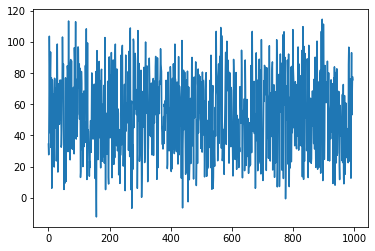

In [5]:
features_dfs['''y(k)'''].plot()

# Least Square Method

In [6]:
best_ls_method = LeastSquaresMethod(biased=True)

In [7]:
best_ls_method.fit(X=np.array(features_dfs.drop(columns=['''y(k)'''])), 
                   y=np.array(features_dfs['''y(k)''']))

In [8]:
ls_pred = best_ls_method.predict(np.array(features_dfs.drop(columns=['''y(k)'''])))

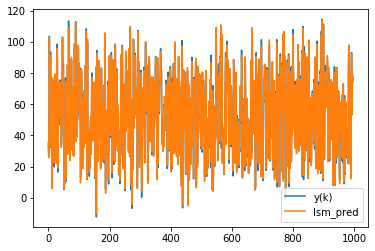

In [9]:
features_dfs['lsm_pred'] = ls_pred
features_dfs[['''y(k)''','lsm_pred']].plot();
features_dfs.drop(columns='lsm_pred', inplace=True)

In [10]:
compose_all_metrics(features_dfs['''y(k)'''], ls_pred, best_ls_method.coef_matrix.shape[0])

{'rmse': 3.816284041502838,
 'determination_coef': 0.9939392435674552,
 'akke_coef': 8235.295871268467}

## Different LS Models

In [11]:
ls_models = []

for y_idx in range(3,0,-1):
    for v_idx in range(3,0, -1):
        print('-'*5 + 'NEW MODEL' + '-'*5)
        coefs_to_ignore = ['''y(k-{})'''.format(i) for i in range(1,y_idx)] + ['''v(k-{})'''.format(i) for i in range(1,v_idx)]
        left_coefs = (set(features_dfs.columns) - {'''y(k)'''}) - set(coefs_to_ignore)
        print('Left coefs: {}'.format(left_coefs))
        print('Model R({},{})'.format(4-y_idx, 4-v_idx))
        
        ls_method = LeastSquaresMethod(biased=True)
        ls_method.fit(X=np.array(features_dfs.drop(columns=['''y(k)'''] + coefs_to_ignore)), 
                      y=np.array(features_dfs['''y(k)''']))
        ls_pred = ls_method.predict(np.array(features_dfs.drop(columns=['''y(k)'''] + coefs_to_ignore)))
        
        temp_results = compose_all_metrics(features_dfs['''y(k)'''], ls_pred, ls_method.coef_matrix.shape[0])
        
        print('Metrics: {}'.format(temp_results))
        
        temp_results['name'] = 'R({},{})'.format(4-y_idx, 4-v_idx)
        
        ls_models.append(temp_results)
        

-----NEW MODEL-----
Left coefs: {'v(k-3)', 'y(k-3)', 'v(k)'}
Model R(1,1)
Metrics: {'rmse': 622.9111865286403, 'determination_coef': 0.010735852052277707, 'akke_coef': 13307.137256685486}
-----NEW MODEL-----
Left coefs: {'v(k-2)', 'v(k-3)', 'y(k-3)', 'v(k)'}
Model R(1,2)
Metrics: {'rmse': 135.18420557714308, 'determination_coef': 0.7853098630455939, 'akke_coef': 11785.95493677986}
-----NEW MODEL-----
Left coefs: {'y(k-3)', 'v(k-1)', 'v(k)', 'v(k-3)', 'v(k-2)'}
Model R(1,3)
Metrics: {'rmse': 57.06988921775482, 'determination_coef': 0.9093655780287017, 'akke_coef': 10928.180331104264}
-----NEW MODEL-----
Left coefs: {'v(k-3)', 'y(k-3)', 'v(k)', 'y(k-2)'}
Model R(2,1)
Metrics: {'rmse': 560.87819731656, 'determination_coef': 0.10925232365318974, 'akke_coef': 13204.551771223943}
-----NEW MODEL-----
Left coefs: {'y(k-2)', 'y(k-3)', 'v(k)', 'v(k-3)', 'v(k-2)'}
Model R(2,2)
Metrics: {'rmse': 82.86740556598116, 'determination_coef': 0.8683957598887969, 'akke_coef': 11300.026599324854}
-----NEW 

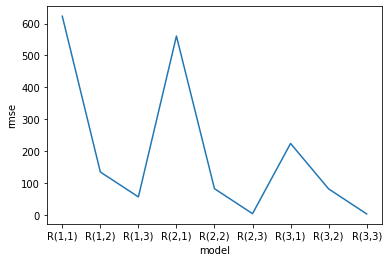

In [12]:
plot_one_model_metric(ls_models, 'rmse')

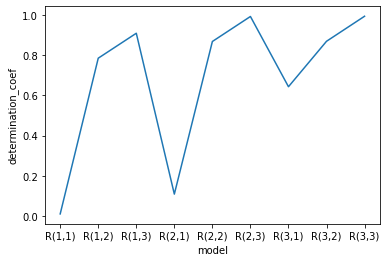

In [13]:
plot_one_model_metric(ls_models, 'determination_coef')

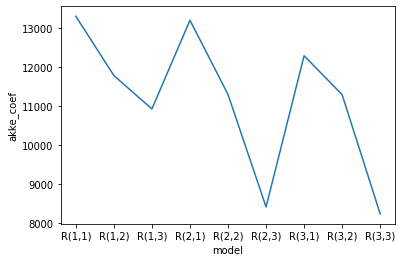

In [14]:
plot_one_model_metric(ls_models, 'akke_coef')

# Recursive Least Square Method

In [15]:
best_rls_method = RecursiveLeastSquaresMethod(coef_matrix_shape=features_dfs.shape[1] - 1, 
                                              biased=True)

In [16]:
rls_pred, rls_coefs = best_rls_method.predict_all(X=np.array(features_dfs.drop(columns=['''y(k)'''])), 
                                                  y=np.array(features_dfs['''y(k)''']))

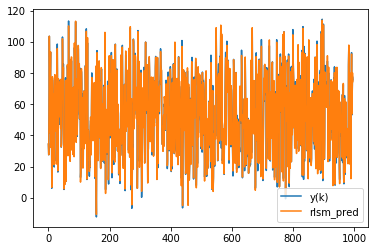

In [17]:
features_dfs['rlsm_pred'] = rls_pred
features_dfs[['''y(k)''','rlsm_pred']].plot();
features_dfs.drop(columns='rlsm_pred', inplace=True)

In [18]:
compose_all_metrics(features_dfs['''y(k)'''], rls_pred, best_rls_method.coef_matrix.shape[0])

{'rmse': 3.685882391284466,
 'determination_coef': 0.9954641341064681,
 'akke_coef': 8200.632939666913}

In [19]:
rls_models = []

for y_idx in range(3,0,-1):
    for v_idx in range(3,0, -1):
        print('-'*5 + 'NEW MODEL' + '-'*5)
        coefs_to_ignore = ['''y(k-{})'''.format(i) for i in range(1,y_idx)] + ['''v(k-{})'''.format(i) for i in range(1,v_idx)]
        left_coefs = (set(features_dfs.columns) - {'''y(k)'''}) - set(coefs_to_ignore)
        print('Left coefs: {}'.format(left_coefs))
        print('Model R({},{})'.format(4-y_idx, 4-v_idx))
        
        rls_method = RecursiveLeastSquaresMethod(coef_matrix_shape=features_dfs.shape[1] - len(coefs_to_ignore) - 1, 
                                                 biased=True)
        rls_pred, _ = rls_method.predict_all(X=np.array(features_dfs.drop(columns=['''y(k)'''] + coefs_to_ignore)), 
                                                     y=np.array(features_dfs['''y(k)''']))
        
        temp_results = compose_all_metrics(features_dfs['''y(k)'''], rls_pred, rls_method.coef_matrix.shape[0])
        
        print('Metrics: {}'.format(temp_results))
        
        temp_results['name'] = 'R({},{})'.format(4-y_idx, 4-v_idx)
        
        rls_models.append(temp_results)

-----NEW MODEL-----
Left coefs: {'v(k-3)', 'y(k-3)', 'v(k)'}
Model R(1,1)
Metrics: {'rmse': 822.3452982155134, 'determination_coef': 0.3852527890064257, 'akke_coef': 13584.06041419186}
-----NEW MODEL-----
Left coefs: {'v(k-2)', 'v(k-3)', 'y(k-3)', 'v(k)'}
Model R(1,2)
Metrics: {'rmse': 138.80308991401733, 'determination_coef': 0.8801427645457269, 'akke_coef': 11812.293658176877}
-----NEW MODEL-----
Left coefs: {'y(k-3)', 'v(k-1)', 'v(k)', 'v(k-3)', 'v(k-2)'}
Model R(1,3)
Metrics: {'rmse': 57.36767308534, 'determination_coef': 0.8401998917137855, 'akke_coef': 10933.369032787716}
-----NEW MODEL-----
Left coefs: {'v(k-3)', 'y(k-3)', 'v(k)', 'y(k-2)'}
Model R(2,1)
Metrics: {'rmse': 809.4929382571178, 'determination_coef': 0.42984759253398047, 'akke_coef': 13570.355342997093}
-----NEW MODEL-----
Left coefs: {'y(k-2)', 'y(k-3)', 'v(k)', 'v(k-3)', 'v(k-2)'}
Model R(2,2)
Metrics: {'rmse': 100.58839236600237, 'determination_coef': 1.0099783977600558, 'akke_coef': 11493.240274023663}
-----NEW MO

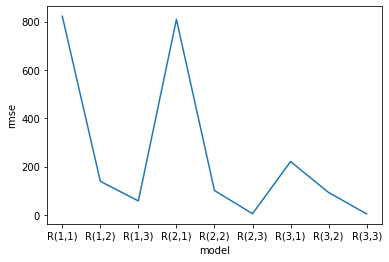

In [20]:
plot_one_model_metric(rls_models, 'rmse')

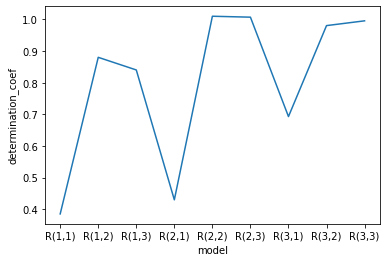

In [21]:
plot_one_model_metric(rls_models, 'determination_coef')

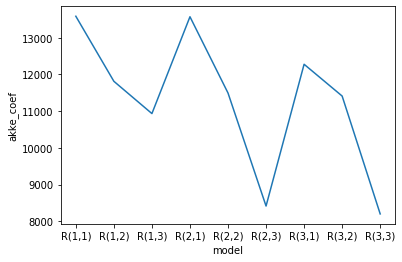

In [22]:
plot_one_model_metric(rls_models, 'akke_coef')

# Compare models

## Metrics

In [23]:
models_dict = {'ls_method':ls_models, 'rls_method':rls_models}

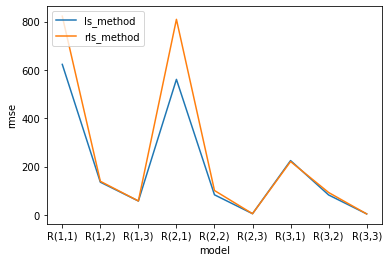

In [24]:
plot_two_models_metric(models_dict, 'rmse')

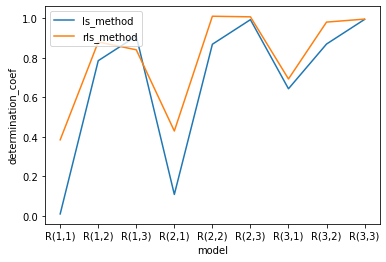

In [25]:
plot_two_models_metric(models_dict, 'determination_coef')

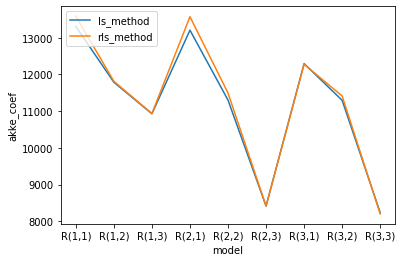

In [26]:
plot_two_models_metric(models_dict, 'akke_coef')

## Coefficients

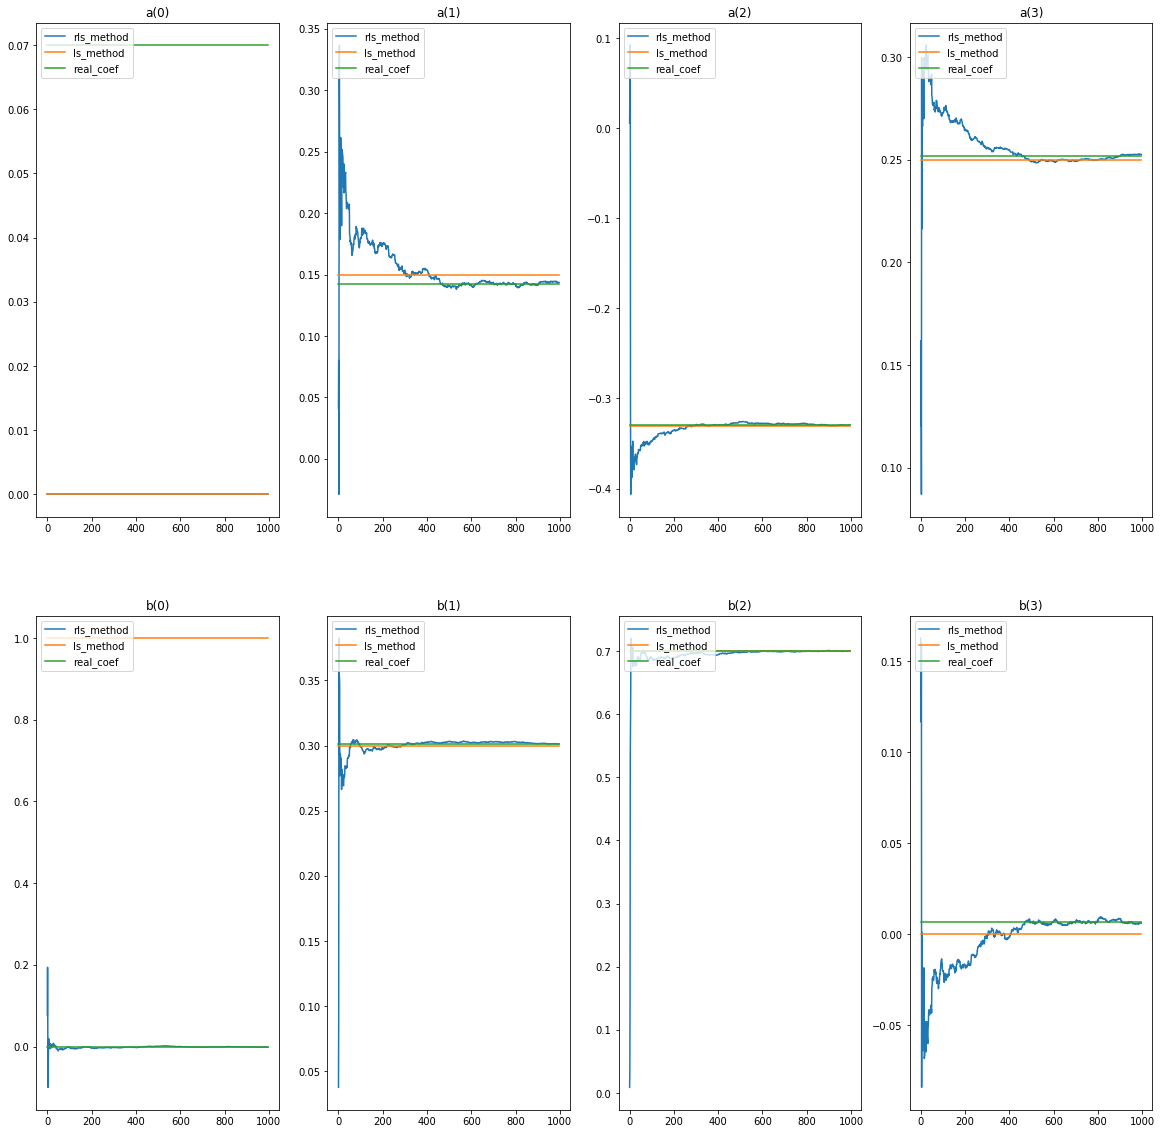

In [27]:
plt.rcParams["figure.figsize"] = (20,20)

fig, axs = plt.subplots(2, 4)

for i in range(len(a_coefs)):
    axs[0,i].set_title('''a({})'''.format(i))
    axs[0,i].plot(np.array(rls_coefs)[:,i])
    axs[0,i].plot([a_coefs[i] for j in range(rls_coefs.shape[0])])
    axs[0,i].plot([best_ls_method.coef_matrix[i] for j in range(rls_coefs.shape[0])])
    axs[0,i].legend(['rls_method','ls_method','real_coef'], loc='upper left')
    

for i in range(len(b_coefs)):
    axs[1,i].set_title('''b({})'''.format(i))
    axs[1,i].plot(np.array(rls_coefs)[:,i+len(a_coefs)])
    axs[1,i].plot([b_coefs[i] for j in range(rls_coefs.shape[0])])
    axs[1,i].plot([best_ls_method.coef_matrix[i+len(a_coefs)] for j in range(rls_coefs.shape[0])])
    axs[1,i].legend(['rls_method','ls_method','real_coef'], loc='upper left')

In [40]:
models_df = dict()
models_df['ls_method'] = pd.DataFrame({k_2: [el[k_2] for el in models_dict['ls_method']] for k_2 in ['name', 'rmse', 'determination_coef', 'akke_coef']})
models_df['rls_method'] = pd.DataFrame({k_2: [el[k_2] for el in models_dict['rls_method']] for k_2 in ['rmse', 'determination_coef', 'akke_coef']})

pd.concat(models_df, axis=1)

ls_method                                               rls_method  \
       name        rmse determination_coef     akke_coef        rmse   
0    R(1,1)  622.911187           0.010736  13307.137257  822.345298   
1    R(1,2)  135.184206           0.785310  11785.954937  138.803090   
2    R(1,3)   57.069889           0.909366  10928.180331   57.367673   
3    R(2,1)  560.878197           0.109252  13204.551771  809.492938   
4    R(2,2)   82.867406           0.868396  11300.026599  100.588392   
5    R(2,3)    4.579266           0.992728   8415.010721    4.580602   
6    R(3,1)  224.519713           0.643433  12293.758138  220.604955   
7    R(3,2)   82.227925           0.869411  11294.303002   92.382891   
8    R(3,3)    3.816284           0.993939   8235.295871    3.685882   

                                    
  determination_coef     akke_coef  
0           0.385253  13584.060414  
1           0.880143  11812.293658  
2           0.840200  10933.369033  
3           0.429848  13570.355343  
4           1.009978  11493.240274  
5           1.007039   8415.301560  
6           0.692933  12276.220966  
7           0.980391  11410.400496  
8           0.995464   8200.632940